In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

import lightgbm, catboost, xgboost
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import scipy.io as io
from pyDOE import lhs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from complexPyTorch.complexLayers import ComplexLinear

import cplxmodule
from cplxmodule import cplx
from cplxmodule.nn import RealToCplx, CplxToReal, CplxSequential, CplxToCplx
from cplxmodule.nn import CplxLinear, CplxModReLU, CplxAdaptiveModReLU, CplxModulus, CplxAngle

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from models import TorchComplexMLP, ImaginaryDimensionAdder, cplx2tensor, ComplexTorchMLP, complex_mse
from preprocess import *

# Model selection
# from sparsereg.model import STRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from RegscorePy.bic import bic

# Fancy optimizers
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew

#### Data preparation

In [2]:
# import numpy as np
# from rkstiff import grids
# from rkstiff import if34

# # Computing the KS sol
# # uniform grid spacing, real-valued u -> construct_x_kx_rfft
# N = 512
# a, b = -10, 10
# x, kx = grids.construct_x_kx_rfft(N, a, b)

# L = kx**2*(1-kx**2)
# def NL(uFFT):
#     u = np.fft.irfft(uFFT)
#     ux = np.fft.irfft(1j*kx*uFFT)
#     return -np.fft.rfft(u*ux)

# u0 = -np.sin(np.pi*x/10)
# u0FFT = np.fft.rfft(u0)
# solver = if34.IF34(linop=L,NLfunc=NL)
# ufFFT = solver.evolve(u0FFT, t0=0, tf=10, h_init=0.2) # store every 20th step in solver.u and solver.t

# U = []
# for uFFT in solver.u:
#     U.append(np.fft.irfft(uFFT))
# U = np.array(U)
# t = np.array(solver.t)

# X_sol, T_sol = np.meshgrid(x, t)
# Exact = U.T

In [3]:
# Loading the KS sol
data = pickle_load("../deephpms_data/KS_simple3.pkl")

t = data['t']
x = data['x']

X_sol, T_sol = np.meshgrid(x, t)
Exact = data['u'].T

Loaded from ../deephpms_data/KS_simple3.pkl


In [4]:
x_star = X_sol.flatten()[:,None]
t_star = T_sol.flatten()[:,None]

X_star = np.hstack((x_star, t_star))
u_star = Exact.T.flatten()[:,None]

# DATA_PATH = '../PDE_FIND_experimental_datasets/kuramoto_sivishinky.mat'
# X, T, Exact = space_time_grid(data_path=DATA_PATH, real_solution=True, uniform=True, x_limit=None, t_limit=None)
# X_star, u_star = get_trainable_data(X, T, Exact)

# Bound
ub = X_star.max(axis=0)
lb = X_star.min(axis=0)

# For identification
N = 250
# idx = np.arange(N)
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_train = X_star[idx,:]
u_train = u_star[idx,:]

print("Training with", N, "samples")

# Unsup data
include_N_res = True; portion = 1
if include_N_res:
    N_res = int(portion)*N
    idx_res = np.array(range(X_star.shape[0]-1))[~idx]
    idx_res = np.random.choice(idx_res.shape[0], N_res, replace=True)
    X_res = X_star[idx_res, :]
    print(f"Training with {N_res} unsup samples")
    X_u_train = np.vstack([X_train, X_res])
    u_train = np.vstack([u_train, torch.rand(X_res.shape[0], 1) - 1000])
    # del X_res
else: print("Not including N_res")
    
# Convert to torch.tensor
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)

# lb and ub are used in adversarial training
scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)

# Feature names
feature_names=('uf', 'u_x', 'u_xx', 'u_xxx', 'u_xxxx')

Training with 250 samples
Training with 250 unsup samples


In [5]:
class Network(nn.Module):
    def __init__(self, model, index2features=None, scale=False, lb=None, ub=None):
        super(Network, self).__init__()
        # pls init the self.model before
        self.model = model
        # For tracking, the default tup is for the burgers' equation.
        self.index2features = index2features
        print("Considering", self.index2features)
        self.diff_flag = diff_flag(self.index2features)
        self.uf = None
        self.scale = scale
        self.lb, self.ub = lb, ub
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x, t):
        if not self.scale: self.uf = self.model(torch.cat([x, t], dim=1))
        else: self.uf = self.model(self.neural_net_scale(torch.cat([x, t], dim=1)))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        
        ### PDE Loss calculation ###
        # Without calling grad
        derivatives = []
        for t in self.diff_flag[0]:
            if t=='uf': derivatives.append(uf)
            elif t=='x': derivatives.append(x)
        # With calling grad
        for t in self.diff_flag[1]:
            out = uf
            for c in t:
                if c=='x': out = self.gradients(out, x)[0]
                elif c=='t': out = self.gradients(out, t)[0]
            derivatives.append(out)
        
        return torch.cat(derivatives, dim=1), u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))
    
    def neural_net_scale(self, inp):
        return 2*(inp-self.lb)/(self.ub-self.lb)-1

In [6]:
class AttentionSelectorNetwork(nn.Module):
    def __init__(self, layers, prob_activation=torch.sigmoid, bn=None, reg_intensity=0.1):
        super(AttentionSelectorNetwork, self).__init__()
        # Nonlinear model, Training with PDE reg.
        assert len(layers) > 1
        self.linear1 = nn.Linear(layers[0], layers[0])
        self.prob_activation = prob_activation
        self.nonlinear_model = TorchMLP(dimensions=layers, activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1))
        self.latest_weighted_features = None
        self.th = 0.05
        self.reg_intensity = reg_intensity
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn):
        return self.nonlinear_model(inn*self.weighted_features(inn))
    
    def weighted_features(self, inn):
        self.latest_weighted_features = self.prob_activation(self.linear1(inn)).mean(axis=0)
        return self.latest_weighted_features
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        reg_term = F.relu(self.latest_weighted_features-self.th)
        return mse_loss+self.reg_intensity*(torch.norm(reg_term, p=0)+(torch.tensor([1.0, 1.0, 2.0, 3.0, 4.0])*reg_term).sum())

class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features=False, mini=None, maxi=None):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
        self.mini = mini
        self.maxi = maxi
        
    def forward(self, X_u_train):
        X_selector, y_selector = self.network.get_selector_data(*dimension_slicing(X_u_train))
        if self.normalize_derivative_features:
            X_selector = (X_selector-self.mini)/(self.maxi-self.mini)
        unsup_loss = self.selector.loss(X_selector, y_selector)
        return self.network.uf, unsup_loss

In [7]:
### Version with normalized derivatives ###
pretrained_state_dict = cpu_load("./saved_path_inverse_small_KS/simple3_semisup_model_state_dict_250labeledsamples.pth")
# pretrained_state_dict = None
use_pretrained_weights = True
lets_pretrain = False

semisup_model = SemiSupModel(network=Network(
                                    model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1],
                                                   activation_function=nn.Tanh,
                                                   bn=nn.LayerNorm, dropout=None),
                                    index2features=feature_names, scale=True, lb=lb, ub=ub),
                            selector=AttentionSelectorNetwork([len(feature_names), 50, 50, 1], prob_activation=nn.Softmax(dim=1), bn=nn.LayerNorm),
                            normalize_derivative_features=True,
                            mini=None,
                            maxi=None)

if use_pretrained_weights:
    print("Use pretrained weights")
    semisup_model.load_state_dict(pretrained_state_dict)
    referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_train))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
#     semisup_model.mini = tmp.min(axis=0)[0].requires_grad_(False)
#     semisup_model.maxi = tmp.max(axis=0)[0].requires_grad_(False)

Using old implementation of TorchMLP. See models.py for more new model-related source code.
Considering ('uf', 'u_x', 'u_xx', 'u_xxx', 'u_xxxx')
Using old implementation of TorchMLP. See models.py for more new model-related source code.
Use pretrained weights


In [8]:
if lets_pretrain:
    print("Pretraining")
    pretraining_optimizer = LBFGSNew(semisup_model.network.parameters(),
                                     lr=1e-1, max_iter=300,
                                     max_eval=int(300*1.25), history_size=150,
                                     line_search_fn=True, batch_mode=False)

    semisup_model.network.train()    
    for i in range(120):
        def pretraining_closure():
            global N, X_u_train, u_train
            if torch.is_grad_enabled():
                pretraining_optimizer.zero_grad()
            # Only focusing on first [:N, :] elements
            mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_train[:N, :])), u_train[:N, :])
            if mse_loss.requires_grad:
                mse_loss.backward(retain_graph=False)
            return mse_loss

        pretraining_optimizer.step(pretraining_closure)
            
        if (i%10)==0:
            l = pretraining_closure()
            curr_loss = l.item()
            print("Epoch {}: ".format(i), curr_loss)

            # Sneak on the test performance...
            semisup_model.network.eval()
            test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()
            string_test_performance = scientific2string(test_performance)
            print('Test MSE:', string_test_performance)
    
#     if best_state_dict is not None: semisup_model.load_state_dict(best_state_dict)
    print("Computing derivatives features")
    semisup_model.eval()
    referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_train))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

#     semisup_model.mini = tmp.min(axis=0)[0].requires_grad_(False)
#     semisup_model.maxi = tmp.max(axis=0)[0].requires_grad_(False)

In [9]:
# performance without semi-supervised training & adversarial exmaples
F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()

0.0001205729422508739

In [10]:
n_test = 50000
n_test = min(n_test, X_star.shape[0])
idx_test = np.arange(n_test)
referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_star[idx_test, :]))

In [11]:
print("PDE Loss", (((u_t+referenced_derivatives[:, 4:5]+(referenced_derivatives[:, 0:1]*referenced_derivatives[:, 1:2])+referenced_derivatives[:, 2:3]))**2).mean())
referenced_derivatives = to_numpy(referenced_derivatives); u_t = to_numpy(u_t)

alpha = 1
const_range = (-1.5, 1.5)

X_input = referenced_derivatives
y_input = u_t

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_input = poly.fit_transform(X_input)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

PDE Loss tensor(0.0410, grad_fn=<MeanBackward0>)


In [12]:
# Set normalize=1
w = TrainSTRidge(X_input[:, :], y_input, 1e-6, 1000, maxit=1000, STR_iters=100, split=0.8, l0_penalty=1, normalize=1)
print("PDE derived using STRidge")
print_pde(w, poly_feature_names[:])

PDE derived using STRidge
u_t = (-0.358023 +0.000000i)u_xx
    + (-0.334331 +0.000000i)u_xxxx
    + (-0.362534 +0.000000i)uf*u_x
   


#### TODO, FT = Finetuning
    - (1) Adversarial training
    - (2) FT network
    - (3) FT selector
    - (4) FT final PINN
    
#### Now, all done!

In [13]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    predictions, unsup_loss = semisup_model(X_train)
    losses = [F.mse_loss(predictions[:N, :], u_train[:N, :]), unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return sum(losses)
    else: return losses

In [14]:
# Joint training
optimizer = MADGRAD([{'params':semisup_model.network.parameters()}, {'params':semisup_model.selector.parameters()}], lr=1e-6)
optimizer.param_groups[0]['lr'] = 1e-11
optimizer.param_groups[1]['lr'] = 1e-1

# Use ~idx to sample adversarial data points
for i in range(500):
    semisup_model.train()
    optimizer.step(pcgrad_closure)
    loss = pcgrad_closure(return_list=True)
    if i%25==0: print(loss)

[tensor(0.0001, grad_fn=<MseLossBackward>), tensor(10.4602, grad_fn=<AddBackward0>)]
[tensor(0.0002, grad_fn=<MseLossBackward>), tensor(0.5674, grad_fn=<AddBackward0>)]
[tensor(0.0003, grad_fn=<MseLossBackward>), tensor(0.3048, grad_fn=<AddBackward0>)]
[tensor(0.0004, grad_fn=<MseLossBackward>), tensor(0.2943, grad_fn=<AddBackward0>)]
[tensor(0.0004, grad_fn=<MseLossBackward>), tensor(0.2915, grad_fn=<AddBackward0>)]
[tensor(0.0006, grad_fn=<MseLossBackward>), tensor(0.2905, grad_fn=<AddBackward0>)]
[tensor(0.0007, grad_fn=<MseLossBackward>), tensor(0.2901, grad_fn=<AddBackward0>)]
[tensor(0.0009, grad_fn=<MseLossBackward>), tensor(0.5897, grad_fn=<AddBackward0>)]
[tensor(0.0015, grad_fn=<MseLossBackward>), tensor(0.3890, grad_fn=<AddBackward0>)]
[tensor(0.0014, grad_fn=<MseLossBackward>), tensor(0.4881, grad_fn=<AddBackward0>)]
[tensor(0.0013, grad_fn=<MseLossBackward>), tensor(0.4893, grad_fn=<AddBackward0>)]
[tensor(0.0011, grad_fn=<MseLossBackward>), tensor(0.3889, grad_fn=<AddBack

In [15]:
# Fine-tuning the solver network
f_opt = torch.optim.LBFGS(semisup_model.network.parameters(), lr=1e-1, max_iter=300, max_eval=int(1.25*300), history_size=300)

def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_train[:N, :])), u_train[:N, :])
    if loss.requires_grad: loss.backward(retain_graph=True)
    return loss

semisup_model.network.train()
semisup_model.selector.eval()

for i in range(200):
    f_opt.step(finetuning_closure)
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())

3.606489372032229e-06
1.2234551149958861e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06
1.2227782235640916e-06


In [16]:
n_test = 50000
n_test = min(n_test, X_star.shape[0])
idx_test = np.arange(n_test)

referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_star[idx_test, :]))
print("PDE Loss", (((u_t+referenced_derivatives[:, 4:5]+(referenced_derivatives[:, 0:1]*referenced_derivatives[:, 1:2])+referenced_derivatives[:, 2:3]))**2).mean())
referenced_derivatives = to_numpy(referenced_derivatives); u_t = to_numpy(u_t)

alpha = 1
const_range = (-1.5, 1.5)

X_input = referenced_derivatives
y_input = u_t

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_input = poly.fit_transform(X_input)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

PDE Loss tensor(0.0188, grad_fn=<MeanBackward0>)


In [17]:
# Set normalize=1
w = TrainSTRidge(X_input[:, :], y_input, 1e-6, 1000, maxit=1000, STR_iters=100, split=0.8, l0_penalty=1, normalize=1)
print("PDE derived using STRidge")
print_pde(w, poly_feature_names[:])

PDE derived using STRidge
u_t = (-0.534833 +0.000000i)u_xx
    + (-0.518928 +0.000000i)u_xxxx
    + (-0.541081 +0.000000i)uf*u_x
   


In [18]:
F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()

4.262957736500539e-05

In [23]:
# save(semisup_model, "./saved_path_inverse_small_KS/simple3_semisup_model_state_dict_250labeledsamples250unlabeledsamples.pth")

In [20]:
X_selector, y_selector = semisup_model.network.get_selector_data(*dimension_slicing(X_train))
X_selector = (X_selector - semisup_model.mini)/(semisup_model.maxi-semisup_model.mini)

In [21]:
f_opt = torch.optim.LBFGS(semisup_model.selector.parameters(), lr=1e-1, max_iter=300, max_eval=int(1.25*300), history_size=300)

def finetuning_closure():
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # Am I forget to normalize the derivative features?, NVM
    loss = F.mse_loss(semisup_model.selector(X_selector), y_selector)
    if loss.requires_grad: loss.backward(retain_graph=True)
    return loss

semisup_model.network.eval()
semisup_model.selector.train()

max_it = 100
for i in range(max_it):
    f_opt.step(finetuning_closure)
    
    if i%5==0 or i==max_it-1:
        loss = finetuning_closure()
        print(loss.item())
        print(np.argsort(semisup_model.selector.latest_weighted_features.detach().numpy()))

0.018755797296762466
[3 2 4 1 0]
0.0182323157787323
[3 2 4 1 0]
0.01856117509305477
[3 2 4 1 0]
0.0181567445397377
[3 2 4 1 0]
0.017883669584989548
[3 2 4 1 0]
0.01821853406727314
[3 2 4 1 0]
0.018407244235277176
[3 2 4 1 0]
0.017803441733121872
[3 2 4 1 0]
0.018001336604356766
[3 2 4 1 0]
0.018376532942056656
[3 2 4 1 0]
0.01822527125477791
[3 2 4 1 0]
0.018470603972673416
[3 2 4 1 0]
0.018414199352264404
[3 2 4 1 0]
0.01809392124414444
[3 2 4 1 0]
0.01806371472775936
[3 2 4 1 0]
0.018282443284988403
[3 2 4 1 0]
0.01818712241947651
[3 2 4 1 0]
0.018230287358164787
[3 2 4 1 0]
0.01874573342502117
[3 2 4 1 0]
0.018568629398941994
[3 2 4 1 0]
0.01843731850385666
[3 2 4 1 0]


In [22]:
feature_importance = semisup_model.selector.latest_weighted_features.detach().numpy()
print("--- Feature importance ranking ---")
for idx in np.argsort(feature_importance)[::-1]:
    print(feature_names[idx], feature_importance[idx])

--- Feature importance ranking ---
uf 0.53533405
u_x 0.31634545
u_xxxx 0.05039167
u_xx 0.049840305
u_xxx 0.04808855


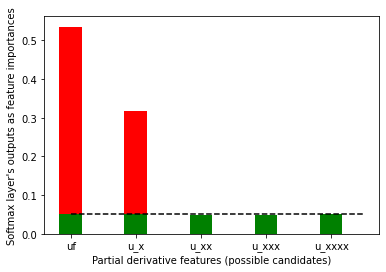

In [27]:
def plot_feature_importance_neural_net(feature_importances, feature_names, threshold=0.2, save_path=None):
    # split it up
    above_threshold = np.maximum(feature_importance - threshold, 0)
    below_threshold = np.minimum(feature_importance, threshold)

    # and plot it
    fig, ax = plt.subplots()
    ax.bar(feature_names, below_threshold, 0.35, color="g")
    ax.bar(feature_names, above_threshold, 0.35, color="r",
            bottom=below_threshold)
    # horizontal line indicating the threshold
    ax.plot([0., 4.5], [threshold, threshold], "k--")
    plt.xlabel("Partial derivative features (possible candidates)")
    plt.ylabel("Softmax layer's outputs as feature importances")
    
    if save_path is not None: fig.savefig(save_path, dpi=200)

plot_feature_importance_neural_net(feature_importance, feature_names,threshold=0.05, save_path="../visualization/ks_feature_importances_selector_with_softmax.png")

#### Tree feature importances

In [13]:
semisup_model = load_weights(semisup_model, "./saved_path_inverse_small_KS/simple3_semisup_model_state_dict_250labeledsamples250unlabeledsamples.pth")

Loaded the model's weights properly


In [14]:
ders, dys = semisup_model.network.get_selector_data(*dimension_slicing(X_star[idx_test, :]))

In [15]:
light = lightgbm.LGBMRegressor(max_depth=3, n_estimators=300, learning_rate=0.1, reg_lambda=1)

In [16]:
light = SklearnModel(model=light, X_train=to_numpy(ders), y_train=to_numpy(dys).ravel(), feature_names=feature_names)
light_feature_importance = light.feature_importance()

Done training
Training MSE: 0.001161289484250926
('uf', 0.2663797226207556)
('u_xx', 0.2501195600191296)
('u_x', 0.2142515542802487)
('u_xxxx', 0.14777618364418937)
('u_xxx', 0.12147297943567671)


In [17]:
tmp = sorted([(v, f) for (f, v) in light_feature_importance.items()])[::-1]
xxx = [f for (f, v) in tmp]
yyy = [v for (f, v) in tmp]

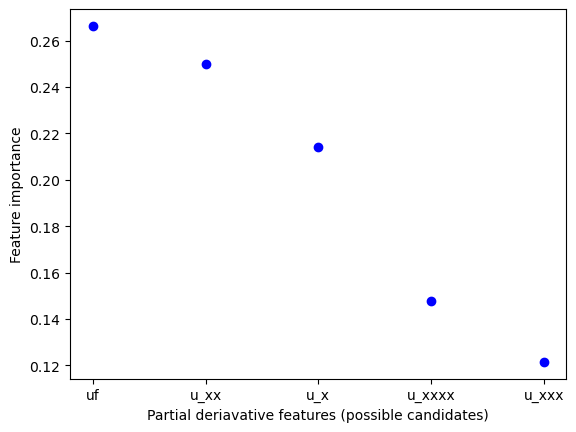

In [19]:
plt.plot(yyy, xxx, 'bo')
plt.ylabel("Feature importance")
plt.xlabel("Partial deriavative features (possible candidates)")
plt.savefig("../visualization/ks_trees_feature_importances.png", dpi=200)
plt.show()